# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                         
Sample_042  O43852;O43852-3;O43852-5                                  13.323
Sample_069  P80108                                                    16.133
Sample_112  Q99784                                                    16.075
Sample_042  P36222                                                    20.552
Sample_129  A0A0A0MSX3;A0A0G2JNZ7;Q08345;Q08345-2;Q08345-5;Q08345-6   17.896
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups 
Sample_012  O95479;R4GMU1     15.897
Sample_183  A0A0G2JRN3        15.972
Sample_040  P27824;P27824-2   12.090
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.637
            A0A075B6Q5                 12.868
            A0A075B6R2                 12.312
            A0A075B6S5                 13.273
            A0A087WSY4                 12.295
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.685
            Q9UI40;Q9UI40-2            14.392
            Q9UIW2                     13.693
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.604
            Q9UP79                     12.047
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.806,15.050,16.842,19.863,13.921,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.229,19.067,...,15.528,15.576,11.114,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.778,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,11.484,17.705,17.039,13.454,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.467,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.133,15.345,17.084,18.708,14.249,19.433,10.966,9.678
Sample_207,15.739,16.877,15.469,16.898,13.834,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.298,12.313,13.977,14.345,13.746,13.515,12.112,12.311,12.257,13.930
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.063,19.067,16.127,...,11.291,12.514,13.216,13.283,12.318,11.042,12.836,12.793,11.744,12.466
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.880,12.382,11.297,14.201,12.513,12.299,13.062,13.077,12.187,12.841
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.200,13.008,12.155,13.007,11.318,13.906,14.074,14.531,12.661,13.644
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.493,13.195,13.257,12.235,13.130,12.284,14.017,12.553,12.537,13.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.344,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 342.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.62it/s]

100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.91it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.96it/s]

100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.10it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.90it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.79it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.86it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.61it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.49it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.29it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.27it/s]

100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.81it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.91it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.94it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.47it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.14it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.70it/s]

100%|██████████| 8/8 [00:01<00:00,  3.36it/s]

100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.47it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.83it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.78it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.41it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.33it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.17it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.15it/s]

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.32it/s]

 30%|███       | 3/10 [00:00<00:01,  4.07it/s]

 40%|████      | 4/10 [00:01<00:01,  3.55it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.36it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.14it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.13it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.26it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.84it/s]

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.89it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.62it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.01it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.83it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.63it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.56it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.01it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.71it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.74it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.78it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.96it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.17it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.92it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.66it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.34it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.90it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:03<00:00,  2.68it/s]

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.20it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.07it/s]

 31%|███       | 4/13 [00:00<00:02,  4.36it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.92it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.85it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.79it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.22it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.16it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.16it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.05it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.97it/s]

100%|██████████| 13/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.51it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.37it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.83it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.57it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.60it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.76it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.43it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.03it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.92it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.79it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.81it/s]

100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.89it/s]

 20%|██        | 3/15 [00:00<00:02,  4.58it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.99it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.90it/s]

 40%|████      | 6/15 [00:01<00:02,  3.84it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.56it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.56it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.49it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.98it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.99it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.93it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.82it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.87it/s]

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

100%|██████████| 15/15 [00:04<00:00,  3.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.042 0.013          0.731 0.366       0.104   
2             0.004 0.003      0.051 0.020          0.710 0.091       0.601   
3             0.006 0.006      0.064 0.024          0.718 0.086       0.653   
4             0.004 0.004      0.041 0.013          0.710 0.079       0.676   
5             0.005 0.005      0.046 0.016          0.727 0.084       0.694   
6             0.005 0.004      0.050 0.020          0.792 0.087       0.816   
7             0.006 0.006      0.061 0.019          0.794 0.086       0.825   
8             0.007 0.006      0.063 0.023          0.817 0.082       0.815   
9             0.006 0.005      0.055 0.022          0.799 0.076       0.833   
10            0.007 0.007      0.050 0.019          0.807 0.081       0.840   
11            0.004 0.003      0.041 0.014          0.800 0.085       0.841   
12            0.005 0.004      0.047 0.019          0.807 0.082       0.838   
13            0.005 0.003      0.052 0.022          0.802 0.083       0.835   
14            0.007 0.005      0.054 0.021          0.799 0.082       0.836   
15            0.007 0.009      0.061 0.028          0.803 0.086       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.175 0.125                  0.544 0.038        0.847   
2          0.103   0.645 0.079                  0.709 0.058        0.779   
3          0.113   0.677 0.080                  0.730 0.059        0.799   
4          0.115   0.686 0.076                  0.735 0.057        0.797   
5          0.112   0.703 0.072                  0.749 0.056        0.807   
6          0.103   0.799 0.070                  0.827 0.062        0.893   
7          0.105   0.804 0.070                  0.832 0.061        0.893   
8          0.111   0.811 0.076                  0.840 0.065        0.909   
9          0.104   0.812 0.070                  0.839 0.061        0.911   
10         0.100   0.819 0.071                  0.845 0.063        0.911   
11         0.107   0.816 0.075                  0.842 0.067        0.909   
12         0.106   0.818 0.073                  0.844 0.064        0.907   
13         0.103   0.815 0.075                  0.841 0.066        0.906   
14         0.105   0.813 0.072                  0.840 0.064        0.904   
15         0.097   0.813 0.066                  0.839 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.088        210.000 0.000  
2          0.067                  0.757 0.085        210.000 0.000  
3          0.067                  0.767 0.088        210.000 0.000  
4          0.063                  0.761 0.084        210.000 0.000  
5          0.063                  0.778 0.083        210.000 0.000  
6          0.052                  0.867 0.060        210.000 0.000  
7          0.051                  0.866 0.061        210.000 0.000  
8          0.050                  0.898 0.050        210.000 0.000  
9          0.052                  0.902 0.049        210.000 0.000  
10         0.052                  0.904 0.049        210.000 0.000  
11         0.054                  0.901 0.051        210.000 0.000  
12         0.053                  0.897 0.051        210.000 0.000  
13         0.054                  0.897 0.052        210.000 0.000  
14         0.054                  0.895 0.051        210.000 0.000  
15         0.052                  0.893 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 472.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.28it/s]

100%|██████████| 3/3 [00:00<00:00,  2.96it/s]

100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.75it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.35it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.61it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.30it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.53it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.72it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.27it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.46it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.47it/s]

100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.59it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.55it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.63it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.39it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.30it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.06it/s]

100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.02it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.48it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.22it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.43it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.26it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.34it/s]

 30%|███       | 3/10 [00:00<00:01,  4.33it/s]

 40%|████      | 4/10 [00:01<00:01,  3.35it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.93it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.69it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.39it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.42it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.60it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.10it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.52it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.29it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.01it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.92it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.17it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.17it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.26it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  3.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.85it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.79it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.18it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.79it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.88it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.94it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.70it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.87it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:03<00:00,  2.88it/s]

100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.95it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.53it/s]

 31%|███       | 4/13 [00:00<00:02,  3.97it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.55it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.61it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.73it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.55it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.47it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.36it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.25it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.86it/s]

100%|██████████| 13/13 [00:03<00:00,  2.62it/s]

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.87it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.10it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.78it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.48it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.30it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.28it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.32it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.23it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.07it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.06it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.14it/s]

100%|██████████| 14/14 [00:06<00:00,  2.14it/s]

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.95it/s]

 20%|██        | 3/15 [00:00<00:03,  3.19it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.62it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:03,  2.49it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.39it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.62it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.83it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.95it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.18it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.26it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:05<00:00,  3.42it/s]

100%|██████████| 15/15 [00:05<00:00,  2.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.055 0.025          0.802 0.299       0.137   
2             0.005 0.004      0.056 0.023          0.698 0.093       0.606   
3             0.005 0.004      0.050 0.021          0.670 0.099       0.583   
4             0.005 0.004      0.053 0.020          0.732 0.094       0.624   
5             0.004 0.003      0.044 0.013          0.728 0.095       0.634   
6             0.004 0.002      0.040 0.010          0.781 0.097       0.735   
7             0.003 0.001      0.038 0.018          0.789 0.102       0.733   
8             0.005 0.005      0.058 0.024          0.784 0.100       0.736   
9             0.006 0.005      0.050 0.019          0.789 0.100       0.746   
10            0.005 0.006      0.042 0.016          0.810 0.101       0.773   
11            0.004 0.002      0.043 0.013          0.802 0.096       0.780   
12            0.004 0.000      0.038 0.005          0.816 0.076       0.799   
13            0.007 0.005      0.069 0.024          0.829 0.086       0.811   
14            0.006 0.005      0.054 0.026          0.824 0.084       0.813   
15            0.005 0.005      0.039 0.013          0.815 0.086       0.809   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.226 0.131                  0.560 0.044        0.852   
2          0.106   0.643 0.080                  0.705 0.060        0.786   
3          0.123   0.616 0.092                  0.684 0.069        0.792   
4          0.117   0.667 0.087                  0.727 0.065        0.811   
5          0.099   0.671 0.070                  0.727 0.054        0.819   
6          0.111   0.751 0.080                  0.790 0.064        0.900   
7          0.104   0.753 0.072                  0.791 0.059        0.900   
8          0.107   0.752 0.074                  0.790 0.060        0.898   
9          0.107   0.761 0.078                  0.797 0.066        0.895   
10         0.108   0.784 0.073                  0.817 0.060        0.909   
11         0.105   0.785 0.074                  0.817 0.062        0.909   
12         0.086   0.804 0.060                  0.833 0.050        0.922   
13         0.101   0.815 0.066                  0.842 0.056        0.926   
14         0.092   0.814 0.064                  0.841 0.054        0.925   
15         0.090   0.808 0.065                  0.835 0.056        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.088        210.000 0.000  
2          0.067                  0.761 0.085        210.000 0.000  
3          0.072                  0.751 0.085        210.000 0.000  
4          0.066                  0.776 0.081        210.000 0.000  
5          0.061                  0.784 0.075        210.000 0.000  
6          0.050                  0.882 0.057        210.000 0.000  
7          0.052                  0.881 0.060        210.000 0.000  
8          0.051                  0.879 0.060        210.000 0.000  
9          0.051                  0.877 0.059        210.000 0.000  
10         0.048                  0.888 0.056        210.000 0.000  
11         0.048                  0.890 0.054        210.000 0.000  
12         0.043                  0.914 0.044        210.000 0.000  
13         0.042                  0.918 0.043        210.000 0.000  
14         0.042                  0.917 0.043        210.000 0.000  
15         0.042                  0.915 0.043 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1270.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 48.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.77it/s]

100%|██████████| 3/3 [00:00<00:00, 18.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 25.68it/s]

100%|██████████| 4/4 [00:00<00:00, 20.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.91it/s]

100%|██████████| 5/5 [00:00<00:00, 18.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 28.46it/s]

100%|██████████| 6/6 [00:00<00:00, 20.45it/s]

100%|██████████| 6/6 [00:00<00:00, 21.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.41it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.56it/s]

100%|██████████| 7/7 [00:00<00:00, 13.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.55it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 17.20it/s]

100%|██████████| 8/8 [00:00<00:00, 16.14it/s]

100%|██████████| 8/8 [00:00<00:00, 16.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.94it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.26it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.15it/s]

100%|██████████| 9/9 [00:00<00:00, 15.90it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.42it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.50it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.36it/s]

100%|██████████| 10/10 [00:00<00:00, 16.24it/s]

100%|██████████| 10/10 [00:00<00:00, 16.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.23it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.74it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.62it/s]

100%|██████████| 11/11 [00:00<00:00, 14.52it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.46it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.42it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.02it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.24it/s]

100%|██████████| 12/12 [00:00<00:00, 12.29it/s]

100%|██████████| 12/12 [00:00<00:00, 12.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.21it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.92it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.99it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.04it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.02it/s]

100%|██████████| 13/13 [00:00<00:00, 13.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 27.01it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.13it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.84it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.01it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.74it/s]

100%|██████████| 14/14 [00:00<00:00, 15.42it/s]

100%|██████████| 14/14 [00:00<00:00, 16.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.25it/s]

 40%|████      | 6/15 [00:00<00:00, 15.13it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.18it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.92it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.94it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.65it/s]

100%|██████████| 15/15 [00:01<00:00, 14.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.039 0.011          0.451 0.438       0.047   
2             0.003 0.002      0.042 0.019          0.636 0.331       0.154   
3             0.004 0.003      0.039 0.018          0.615 0.222       0.186   
4             0.003 0.000      0.042 0.014          0.584 0.257       0.192   
5             0.004 0.002      0.043 0.017          0.563 0.223       0.195   
6             0.006 0.006      0.051 0.024          0.583 0.164       0.351   
7             0.007 0.007      0.064 0.026          0.584 0.139       0.401   
8             0.006 0.005      0.057 0.026          0.567 0.131       0.392   
9             0.006 0.007      0.057 0.021          0.572 0.132       0.399   
10            0.007 0.006      0.055 0.027          0.553 0.132       0.385   
11            0.005 0.004      0.041 0.012          0.539 0.132       0.370   
12            0.005 0.003      0.044 0.016          0.523 0.124       0.366   
13            0.006 0.005      0.058 0.020          0.532 0.119       0.378   
14            0.006 0.004      0.055 0.017          0.529 0.108       0.406   
15            0.005 0.004      0.055 0.022          0.524 0.113       0.408   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.056   0.082 0.091                  0.515 0.026        0.724   
2          0.099   0.237 0.137                  0.551 0.042        0.670   
3          0.095   0.269 0.113                  0.545 0.039        0.633   
4          0.104   0.270 0.120                  0.540 0.042        0.609   
5          0.094   0.272 0.106                  0.533 0.040        0.582   
6          0.105   0.426 0.100                  0.574 0.067        0.597   
7          0.098   0.465 0.092                  0.588 0.066        0.602   
8          0.101   0.453 0.093                  0.579 0.067        0.593   
9          0.106   0.462 0.100                  0.585 0.072        0.586   
10         0.106   0.446 0.100                  0.574 0.072        0.583   
11         0.105   0.430 0.097                  0.563 0.069        0.571   
12         0.101   0.423 0.094                  0.556 0.068        0.573   
13         0.094   0.435 0.090                  0.563 0.067        0.564   
14         0.092   0.452 0.082                  0.565 0.065        0.570   
15         0.097   0.450 0.084                  0.562 0.068        0.568   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.674 0.076        210.000 0.000  
2          0.078                  0.625 0.081        210.000 0.000  
3          0.090                  0.585 0.087        210.000 0.000  
4          0.091                  0.564 0.096        210.000 0.000  
5          0.092                  0.536 0.086        210.000 0.000  
6          0.079                  0.566 0.085        210.000 0.000  
7          0.074                  0.574 0.079        210.000 0.000  
8          0.074                  0.558 0.081        210.000 0.000  
9          0.079                  0.554 0.087        210.000 0.000  
10         0.083                  0.554 0.086        210.000 0.000  
11         0.085                  0.546 0.090        210.000 0.000  
12         0.085                  0.546 0.086        210.000 0.000  
13         0.087                  0.534 0.084        210.000 0.000  
14         0.086                  0.537 0.087        210.000 0.000  
15         0.084                  0.540 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,13,7
score_time,3,13,7
test_precision,8,13,2
test_recall,11,14,15
test_f1,10,13,7
test_balanced_accuracy,10,13,7
test_roc_auc,10,13,1
test_average_precision,10,13,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.48it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.02it/s]

 31%|███       | 4/13 [00:00<00:02,  4.38it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.91it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.06it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.54it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.83it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.87it/s]

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

100%|██████████| 13/13 [00:04<00:00,  3.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1063.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.61it/s]

 30%|███       | 3/10 [00:00<00:01,  4.16it/s]

 40%|████      | 4/10 [00:00<00:01,  4.00it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.87it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.86it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.93it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.24it/s]

100%|██████████| 10/10 [00:02<00:00,  2.87it/s]

100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


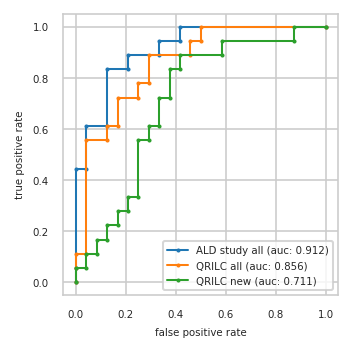

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.444     0.000 0.111     0.042 0.056
3          0.042 0.444     0.042 0.111     0.042 0.111
4          0.042 0.611     0.042 0.556     0.083 0.111
5          0.125 0.611     0.125 0.556     0.083 0.167
6          0.125 0.833     0.125 0.611     0.125 0.167
7          0.208 0.833     0.167 0.611     0.125 0.222
8          0.208 0.889     0.167 0.722     0.167 0.222
9          0.333 0.889     0.250 0.722     0.167 0.278
10         0.333 0.944     0.250 0.778     0.208 0.278
11         0.417 0.944     0.292 0.778     0.208 0.333
12         0.417 1.000     0.292 0.889     0.250 0.333
13         1.000 1.000     0.458 0.889     0.250 0.556
14           NaN   NaN     0.458 0.944     0.292 0.556
15           NaN   NaN     0.500 0.944     0.292 0.611
16           NaN   NaN     0.500 1.000     0.333 0.611
17           NaN   NaN     1.000 1.000     0.333 0.722
18           NaN   NaN       NaN   NaN     0.375 0.722
19           NaN   NaN       NaN   NaN     0.375 0.833
20           NaN   NaN       NaN   NaN     0.417 0.833
21           NaN   NaN       NaN   NaN     0.417 0.889
22           NaN   NaN       NaN   NaN     0.583 0.889
23           NaN   NaN       NaN   NaN     0.583 0.944
24           NaN   NaN       NaN   NaN     0.875 0.944
25           NaN   NaN       NaN   NaN     0.875 1.000
26           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P10644;P10644-2
1,A0A0J9YX35,P60709;P63261,None
2,P01258;P01258-2;P06881,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,None
3,P61981,P10636-2;P10636-6,None
4,P14174,P61981,None
5,P04075,A0A0A0MRJ7;P12259,None
6,Q9Y2T3;Q9Y2T3-3,P14174,None
7,P08294,P04075,None
8,P00338;P00338-3,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


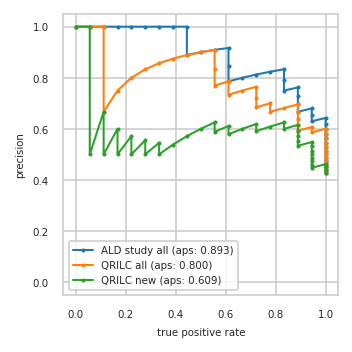

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.593 0.889
16         0.654 0.944     0.615 0.889     0.615 0.889
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.625 0.833
19         0.696 0.889     0.696 0.889     0.609 0.778
20         0.727 0.889     0.682 0.833     0.591 0.722
21         0.762 0.889     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.789 0.833     0.684 0.722     0.579 0.611
24         0.833 0.833     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.917 0.611     0.833 0.556     0.500 0.333
31         0.909 0.556     0.909 0.556     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


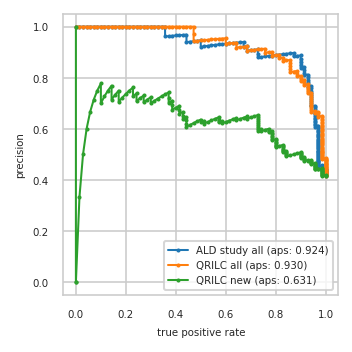

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


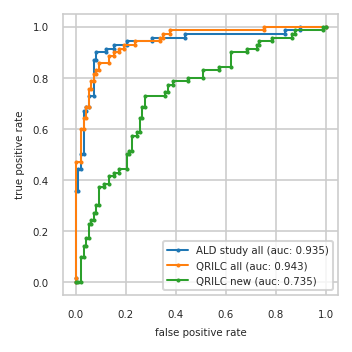

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}